# Playing MissPackman with DQN

* playing with ehe environment to see what is needed

In [1]:
import pyvirtualdisplay, os
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [2]:
env_name = "MsPacman-v4"

In [3]:
import cv2 
import gym
import gym.spaces
import numpy as np
import collections
import torch
import torch.nn as nn
import torch.optim as optim
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

In [4]:
env = gym.make(env_name)

In [5]:
print(env.observation_space.shape)

(210, 160, 3)


In [6]:
print(env.action_space.n)

9


In [7]:
print(env.unwrapped.get_action_meanings())

['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


0.0


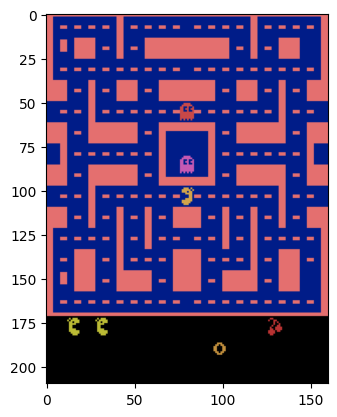

In [8]:
from IPython.display import clear_output
import time
state = env.reset()
plt.imshow(state)
plt.show()
for i in range(88):
    time.sleep(0.01)
    char = '3'#input()
    if char == 'q':
        break
    clear_output()
    state, reward, done, info = env.step(int(char))
    print(reward)
    plt.imshow(state)
    plt.show()

0.0


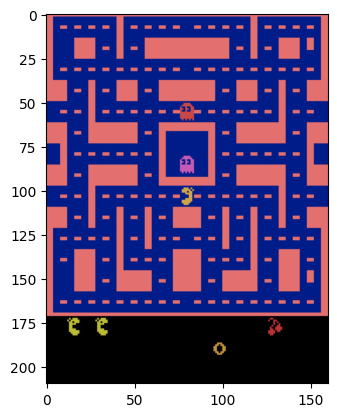

In [9]:
plt.imshow(state)
plt.show()
while(True):
    time.sleep(0.1)
    char = "1"
    if char == 'q':
        break
    clear_output()
    state, reward, done, info = env.step(int(char))
    print(reward)
    plt.imshow(state)
    plt.show()
    break #

* first needs 88 steps of nothing ness!

#### Create wrappers accordingly!

In [10]:
START_FRAME_COUNT = 88

class RestartEnv(gym.Wrapper): # press fire at the beginning of episode
    def __init__(self, env=None): 
        super(RestartEnv, self).__init__(env) # pass self.env env
        pass
    
    def step(self, action):
        obs, reward, is_done, info = self.env.step(action) # just pass
        if(info['ale.lives'] == 2):
            is_done = True
        return obs, reward, is_done, info
        
    def reset(self): # on reset
        self.env.reset()
        for _ in range(START_FRAME_COUNT):
            obs, _, done, _ = self.env.step(0)
        if done:
            self.env.reset()
        return obs

In [11]:
class MaxAndSkipEnv(gym.Wrapper): # skips frames and obs is max to prevent flickering
    def __init__(self, env = None, skip=4):
        # return only every "skip"-th frame
        super(MaxAndSkipEnv, self).__init__(env)
        self._obs_buffer = collections.deque(maxlen=2) # most recent observations
        self._skip = skip
        pass
    
    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
                
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info
    
    def reset(self): # clear buffer and init
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs) # save the first obs!
        return obs

In [12]:
class ProcessFrame84(gym.ObservationWrapper): # resize and grayscale image
    def __init__(self, env = None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(128, 128, 1), dtype=np.uint8)
        pass
    
    def observation(self, obs):
        return ProcessFrame84.process(obs) # do not use self.process?
    
    @staticmethod
    def process(frame):
        if frame.size == 210*160*3:
            img = np.reshape(frame, [210, 160, 3]).astype(np.float32)
        elif frame.size == 250*160*3:
            img = np.reshape(frame, [250, 160, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1]*0.587 + img[:, :, 2]*0.114 # grayscale formula
        resized_screen = cv2.resize(img, (128, 156), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[:128, :] # crop height
        x_t = np.reshape(x_t, [128, 128, 1])
        return x_t.astype(np.uint8)

In [13]:
class BufferWrapper(gym.ObservationWrapper): # give buffered past observations as output
    def __init__(self, env, n_steps, dtype=np.float32): # buffer for n_steps
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(
            old_space.low.repeat(n_steps, axis=0),
            old_space.high.repeat(n_steps, axis=0), dtype=dtype)
        pass
    
    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype) # fill the buffer
        return self.observation(self.env.reset())
    
    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:] # just like a deque buffer
        self.buffer[:-1] = observation
        return self.buffer

In [14]:
class ImageToPytorch(gym.ObservationWrapper): # HWC to CHW required by pytorch
    def __init__(self, env):
        super(ImageToPytorch, self).__init__(env)
        old_shape = self.observation_space.shape
        new_shape = (old_shape[-1], old_shape[0], old_shape[1])
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=new_shape, dtype=np.float32)
        pass
    
    def observation(self, observation):
        return np.moveaxis(observation, 2,0)

In [15]:
class ScaledFloatFrame(gym.ObservationWrapper): # buffer to float , 0~1
    def observation(self, observation):
        return np.array(observation).astype(np.float32) / 255.0

In [16]:
class RewardWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def reward(self, reward):
        # modify rew
        return reward / 100.0 # reward is big on this

In [17]:
def wrap_env(env):
    env = RestartEnv(env)
    env = MaxAndSkipEnv(env, skip=2)
    env = ProcessFrame84(env)
    env = ImageToPytorch(env)
    env = BufferWrapper(env, n_steps=4)
    env = ScaledFloatFrame(env)
    env = RewardWrapper(env)
    return env

In [18]:
env = gym.make(env_name)
env = wrap_env(env)

In [19]:
state = env.reset()
print(state.shape)

(4, 128, 128)


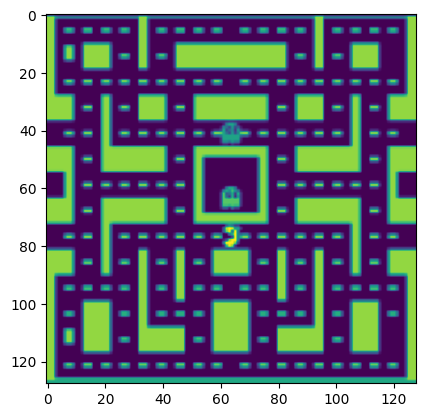

In [20]:
plt.imshow(state[0])

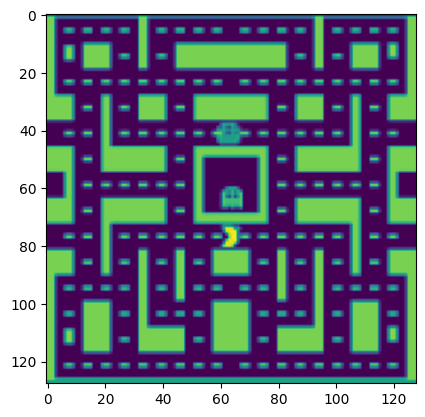

In [21]:
state, reward, done, info = env.step(1)

plt.imshow(state[0])

In [22]:
print(info['ale.lives'])

3


In [23]:
print(done)

False


### The DQN model

In [24]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions): # input shape doesn't regard batch size!
        super(DQN, self).__init__()
        
        self.conv = nn.Sequential(
            # input channel_n, output_channel_n, filter size, stride
            nn.Conv2d(input_shape[0], 32, kernel_size = 8, stride = 4), 
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        conv_out_size = self._get_conv_out(input_shape)
        print("conv out size: ",conv_out_size)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512), # input size, output size
            nn.ReLU(),
            nn.Linear(512, n_actions)# get Q(s,a)
        )
        
    def _get_conv_out(self, shape): # get output shape of conv net
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size())) # get the total number of pixels
    
    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1) # what does this do? -> flatten!
        return self.fc(conv_out)

### Training

In [25]:
MEAN_REWARD_BOUND = 50

GAMMA = 0.99 # gamma value
BATCH_SIZE = 32
REPLAY_SIZE = 50000
LEARNING_RATE = 1e-3
SYNC_TARGET_FRAMES = 1000 # sync between target
REPLAY_START_SIZE = 50000

EPSILON_DECAY_LAST_FRAME = 1500000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01

In [26]:
Experience = collections.namedtuple("Experience", field_names=["state", "action", "reward","done", "new_state"])

class ExperienceBuffer: # return better ones to see
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size,
                                   replace=False)
        states, actions, rewards, dones, next_states = \
            zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), \
               np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), \
               np.array(next_states)

In [27]:
class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state = env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net, epsilon=0.0, device="cpu"):
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(self.state, action, reward,
                         is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
            
        return done_reward

In [28]:
def calc_loss(batch, net, tgt_net, device="cpu"): # to train net
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(np.array(
        states, copy=False)).to(device)
    next_states_v = torch.tensor(np.array(
        next_states, copy=False)).to(device)
    actions_v = torch.tensor(actions).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    done_mask = torch.BoolTensor(dones).to(device)

    state_action_values = net(states_v).gather(
        1, actions_v.unsqueeze(-1)).squeeze(-1)
    with torch.no_grad():
        next_state_values = tgt_net(next_states_v).max(1)[0]
        next_state_values[done_mask] = 0.0
        next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * GAMMA + \
                                   rewards_v
    return nn.MSELoss()(state_action_values,
                        expected_state_action_values)

In [29]:
# main
device = torch.device("cuda") ###### cuda!!

net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)

writer = SummaryWriter(comment="-"+env_name)
print(net)

conv out size:  9216
conv out size:  9216
DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=9216, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=9, bias=True)
  )
)


In [ ]:
SAVE_SIZE = 10000

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
LEARNING_RATE_END = 1e-5

total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_m_reward = None

while True:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START*(1-(frame_idx-REPLAY_START_SIZE) / EPSILON_DECAY_LAST_FRAME)) # use max!!
    optimizer.lr = max(LEARNING_RATE_END, LEARNING_RATE*(1-(frame_idx-REPLAY_START_SIZE) / EPSILON_DECAY_LAST_FRAME))
    
    reward = agent.play_step(net, epsilon, device=device)
    if reward is not None: # episode is over
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts) # frames per sec
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(total_rewards[-100:])
        print("%d: done %d games, lr %.5f reward %.3f, "
              "eps %.2f, speed %.2f f/s" % (
                  frame_idx, len(total_rewards),optimizer.lr, m_reward, epsilon, speed))
        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", m_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)
        writer.add_scalar("learning_rate", optimizer.lr, frame_idx)
        if best_m_reward is None or best_m_reward < m_reward:
            torch.save(net.state_dict(), env_name+"-best_%.0f.dat" % m_reward)
            if best_m_reward is not None:
                print("Best reward updated %.3f -> %.3f" %(best_m_reward, m_reward))
            best_m_reward = m_reward
            
        if m_reward > MEAN_REWARD_BOUND:
            print("Solved in %d frames!: " % frame_idx)
            break
            
            
    if len(buffer) < REPLAY_START_SIZE: # not enough buffer
        continue
        
    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict()) # sync two nets
        
    if frame_idx % SAVE_SIZE == 0:
        torch.save(net.state_dict(), env_name+"-save-"+str(frame_idx)+".dat")
        test_env = gym.make(env_name)
        test_env = gym.wrappers.Monitor(test_env, env_name + "_record_saved_"+str(frame_idx), force=True) # attach a monitor!
        test_env = wrap_env(test_env)
        test_state = test_env.reset()

        while True:
            state_v = torch.tensor(np.array([test_state], copy=False)).to(device)
            q_vals = net(state_v).cpu().data.numpy()[0] # need data to get it out!
            action = np.argmax(q_vals) # max idx
            test_state, reward, done, _ = test_env.step(action)
            if done:
                break
        test_env.close()
    
    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE) # train with every new steps
    loss_t = calc_loss(batch, net, tgt_net, device=device)
    loss_t.backward()
    optimizer.step()
    
writer.close()

79: done 1 games, lr 0.00103 reward 1.500, eps 1.03, speed 612.70 f/s
148: done 2 games, lr 0.00103 reward 1.500, eps 1.03, speed 466.10 f/s
223: done 3 games, lr 0.00103 reward 1.200, eps 1.03, speed 592.65 f/s
294: done 4 games, lr 0.00103 reward 1.150, eps 1.03, speed 581.95 f/s
397: done 5 games, lr 0.00103 reward 1.260, eps 1.03, speed 647.54 f/s
465: done 6 games, lr 0.00103 reward 1.183, eps 1.03, speed 579.80 f/s
517: done 7 games, lr 0.00103 reward 1.143, eps 1.03, speed 528.80 f/s
597: done 8 games, lr 0.00103 reward 1.188, eps 1.03, speed 601.42 f/s
679: done 9 games, lr 0.00103 reward 1.189, eps 1.03, speed 605.14 f/s
753: done 10 games, lr 0.00103 reward 1.210, eps 1.03, speed 576.85 f/s
831: done 11 games, lr 0.00103 reward 1.200, eps 1.03, speed 595.10 f/s
923: done 12 games, lr 0.00103 reward 1.225, eps 1.03, speed 627.79 f/s
1044: done 13 games, lr 0.00103 reward 1.262, eps 1.03, speed 665.41 f/s
1108: done 14 games, lr 0.00103 reward 1.207, eps 1.03, speed 552.36 f/s


## model in action

In [ ]:
torch.save(net.state_dict(), env_name+"-11090522.dat" % m_reward)

In [37]:
import os


def record_video(MODEL_NAME = "MsPacman-v4-best_3.dat", times=100):
    best_reward = 0.0
    for i in range(times): 
        env = gym.make(env_name)
        env = gym.wrappers.Monitor(env, env_name + "_record_"+MODEL_NAME[:-4], force=True) # attach a monitor!
        env = wrap_env(env)

        net = DQN(env.observation_space.shape, env.action_space.n)
        state = torch.load(MODEL_NAME, map_location = lambda stg, _:stg) # load dict from gpu to cpu!
        net.load_state_dict(state)

        state = env.reset()
        total_reward = 0.0
        c = collections.Counter()

        while True:
            state_v = torch.tensor(np.array([state], copy=False))
            q_vals = net(state_v).data.numpy()[0] # need data to get it out!
            action = np.argmax(q_vals) # max idx
            c[action] += 1
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        print("Total reward: %.2f" %total_reward)
        print("Action counts:", c)

        env.close() # stop recording
        
        if(best_reward < total_reward):
            best_reward = total_reward
            os.system("cp -r "+env_name + "_record_"+MODEL_NAME[:-4]+"/ "+ env_name + "_record_"+MODEL_NAME[:-4]+"best"+'/')
            print("best_reward changed to ",best_reward)
            
    print("best_reward: ",best_reward)

In [38]:
record_video(times=100)

conv out size:  9216
Total reward: 0.60
Action counts: Counter({2: 103})
best_reward changed to  0.6
conv out size:  9216
Total reward: 0.60
Action counts: Counter({2: 76})
conv out size:  9216
Total reward: 0.60
Action counts: Counter({2: 78})
conv out size:  9216
Total reward: 0.60
Action counts: Counter({2: 48})
conv out size:  9216
Total reward: 0.60
Action counts: Counter({2: 104})
conv out size:  9216


KeyboardInterrupt: 